# [Module 4.1] 세이지 메이커 배포 및 인퍼런스

본 워크샵의 모든 노트북은 `conda_python3` 추가 패키지를 설치하고 모두 이 커널 에서 작업 합니다.

- 1. 배포 준비
- 2. 로컬 앤드포인트 생성
- 3. 로컬 추론

## 참고:

- 세이지 메이커의 모델 배포 및 추론 Python SDK 가이드.
    - [Deploying directly from model artifacts](https://sagemaker.readthedocs.io/en/stable/frameworks/tensorflow/deploying_tensorflow_serving.html#deploying-directly-from-model-artifacts)



---    
    

# 1. 배포 준비

이전 노트북에서 인퍼런스 테스트를 완료한 티펙트를 가져옵니다.

In [1]:
%store 

Stored variables and their in-db values:
data_dir                                -> 'data/cifar10'
eval_dir                                -> 'data/cifar10/eval'
keras_horovod_artifact_path             -> 's3://sagemaker-us-east-1-227612457811/cifar10-dis
keras_script_artifact_path              -> 's3://sagemaker-us-east-1-227612457811/cifar10-202
tf2_horovod_artifact_path               -> 's3://sagemaker-us-east-1-227612457811/cifar10-tf-
tf2_script_artifact_path                -> 's3://sagemaker-us-east-1-227612457811/cifar10-202
train_dir                               -> 'data/cifar10/train'
validation_dir                          -> 'data/cifar10/validation'


In [2]:
%store -r tf2_horovod_artifact_path
%store -r keras_script_artifact_path


## 모델 아티펙트 지정

- 앞에서 실행하여 생성된 모델 아티펙트의 경로를 지정 함.
- 주석을 제거하시고 사용하시면 됨.

In [3]:
# artifact_path = tf2_horovod_artifact_path
artifact_path = keras_script_artifact_path

In [4]:
print("artifact_path: ", artifact_path)

artifact_path:  s3://sagemaker-us-east-1-227612457811/cifar10-2021-10-11-10-10-05-339/output/model.tar.gz


In [5]:
import sagemaker
import os
import time


sagemaker_session = sagemaker.Session()

bucket = sagemaker_session.default_bucket()
prefix = "sagemaker/DEMO-pytorch-cnn-cifar10"

role = sagemaker.get_execution_role()

# 2. 모델 배포 준비

- 앞에 노트북에서 도커 이미지를 다운로드하여서 용량이 부족할 수 있기에, 용량 부족시 실행함.

## 시스템의 이전 도커 컨테이너 삭제
- 아래와 같은 명령어를 사용하여 저장 공간을 확보 합니다.

In [6]:
! df -h

Filesystem      Size  Used Avail Use% Mounted on
devtmpfs         30G   72K   30G   1% /dev
tmpfs            30G     0   30G   0% /dev/shm
/dev/xvda1      109G   98G   11G  91% /
/dev/xvdf        20G  571M   18G   4% /home/ec2-user/SageMaker


In [8]:
! docker container prune -f 
! rm -rf /tmp/tmp*
! df -h

Deleted Containers:
3726dfadbc76a654256fb330e667c65598294a001d71ae1a72a127bc2f85b38b
6f19020ebdc15bd8bf1768b81375a4604957d8f593fd779d74a0e27a94a6a1d8
65172003b2cbf89fd293b2d5594b360ba36a9d165c62fa18af53c63fffaf9820
1adc6edaee00d83533269416ff91e26f5d366cf6cad11d36b25b6a88a5100570
e5006b77b0921bce5eca96f12be3ad07aeb6c2490a636902af4d9b16109b6eae
a4d4778958f933dc84fcf841e294bba9b4e7d43e2a68e8fbe36667d9495f437c

Total reclaimed space: 880.2kB
rm: cannot remove ‘/tmp/tmp0_fq89jx/model/checkpoint-1.h5’: Permission denied
rm: cannot remove ‘/tmp/tmp0_fq89jx/model/1/saved_model.pb’: Permission denied
rm: cannot remove ‘/tmp/tmp0_fq89jx/model/1/variables/variables.index’: Permission denied
rm: cannot remove ‘/tmp/tmp0_fq89jx/model/1/variables/variables.data-00000-of-00001’: Permission denied
rm: cannot remove ‘/tmp/tmp0_fq89jx/model/1/assets’: Permission denied
rm: cannot remove ‘/tmp/tmp47yolppx/model/1/saved_model.pb’: Permission denied
rm: cannot remove ‘/tmp/tmp47yolppx/model/1/variables/var

In [9]:
! df -h
! docker image prune -f --all
! df -h

Filesystem      Size  Used Avail Use% Mounted on
devtmpfs         30G   72K   30G   1% /dev
tmpfs            30G     0   30G   0% /dev/shm
/dev/xvda1      109G   98G   11G  91% /
/dev/xvdf        20G  571M   18G   4% /home/ec2-user/SageMaker
Deleted Images:
untagged: 763104351884.dkr.ecr.us-east-1.amazonaws.com/tensorflow-training:2.4.1-gpu-py37
untagged: 763104351884.dkr.ecr.us-east-1.amazonaws.com/tensorflow-training@sha256:bcccb4db71c88b2c8e437438bcc3891b1f1be2e00d59e5553bcce7be2d152c83
deleted: sha256:8467bc1c5070c5fd5b3ca831313ff905fb5df83ed8b87e104436366587100f67
deleted: sha256:b20fe8e51f7c91ed70670f641c12e5982a641b645728e2155d80fe61fe5d394a
deleted: sha256:908ce8858f0479b4eb3f1376f91eebe93a3633166c17a75113ce3a166c46f4d3
deleted: sha256:60d90f1b143ba4fdd36b8cf0fcefbf4738e6327d0a90bce1e998fb51b9f5c20a
deleted: sha256:b4211cf5c630957e3e546a8f45ee86d1c182ca1bd040b9a19e1de86b34e65c6a
deleted: sha256:0ac56ef85f6f2fe400ebc15f6f12e5bdb426278a9425d2a6bb06285d0ae1cb97
deleted: sha256:b43

# 3. 세이지 메이커 로컬 엔드포인트 생성
- 이 과정은 세이지 메이커 엔드포인트를 생성합니다.



In [10]:
from sagemaker.tensorflow import TensorFlowModel

sm_tf_model = TensorFlowModel(
                        model_data= artifact_path,
                        framework_version='2.4.1',
                        #py_version='py37',    
                        role=role,
        )

instance_type = 'local_gpu'
endpoint_name = "sm-endpoint-cifar10-tf2-{}".format(int(time.time()))

sm_tf_predictor = sm_tf_model.deploy(
                           instance_type= instance_type, 
                           initial_instance_count=1, 
                           endpoint_name=endpoint_name,
                           wait=True,
                        )

update_endpoint is a no-op in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


Attaching to 61df1bq5a2-algo-1-gi16m
61df1bq5a2-algo-1-gi16m | INFO:__main__:PYTHON SERVICE: False
61df1bq5a2-algo-1-gi16m | INFO:__main__:starting services
61df1bq5a2-algo-1-gi16m | INFO:__main__:using default model name: model
61df1bq5a2-algo-1-gi16m | INFO:__main__:tensorflow serving model config: 
61df1bq5a2-algo-1-gi16m | model_config_list: {
61df1bq5a2-algo-1-gi16m |   config: {
61df1bq5a2-algo-1-gi16m |     name: 'model'
61df1bq5a2-algo-1-gi16m |     base_path: '/opt/ml/model'
61df1bq5a2-algo-1-gi16m |     model_platform: 'tensorflow'
61df1bq5a2-algo-1-gi16m |     model_version_policy: {
61df1bq5a2-algo-1-gi16m |       specific: {
61df1bq5a2-algo-1-gi16m |         versions: 1
61df1bq5a2-algo-1-gi16m |       }
61df1bq5a2-algo-1-gi16m |     }
61df1bq5a2-algo-1-gi16m |   }
61df1bq5a2-algo-1-gi16m | }
61df1bq5a2-algo-1-gi16m | 
61df1bq5a2-algo-1-gi16m | 
61df1bq5a2-algo-1-gi16m | INFO:__main__:tensorflow version info:
61df1bq5a2-algo-1-gi16m | 2021-10-11 11:51:25.941472: W external/

# 4. 로컬 추론: 샘플로 9개 만 추론
- 준비된 입력 데이터로 로컬 엔드포인트에서 추론

## 데이터 읽기 단계

- `data/cifar10/eval/eval-tfrecords` 일고  9 batch_size 로 할당하여, TF dataset를 생성 합니다.
- 1 개의 배치 (9개의 이미지, 레이블 포함) 를 읽음
- 1 개의 배치 추론

In [11]:
import matplotlib.pyplot as plt
import numpy as np
from src.utils import _input, classes

batch_size = 9
sample_dir = 'data/cifar10/eval'
sample_dataset = _input(1, batch_size, sample_dir, 'eval')

## 추론 함수 정의

In [12]:
def predict(predictor, data):
    predictions = predictor.predict(data)['predictions']
    
    return predictions

## 9개의 이미지의 실제 값과 추론 값 보여주기

images shape:  (9, 32, 32, 3)


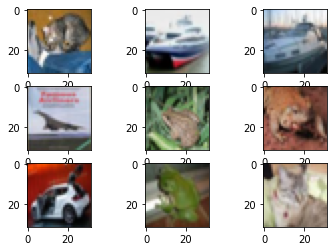

61df1bq5a2-algo-1-gi16m | 172.18.0.1 - - [11/Oct/2021:11:51:52 +0000] "POST /invocations HTTP/1.1" 200 1357 "-" "python-urllib3/1.26.6"

Ground Truth:
  cat ship ship plane frog frog  car frog  cat
Predicted Labels:
  cat ship ship plane frog frog  car frog deer


In [13]:
import time
# 1개의 배치만을 가져옴
images, labels = iter(sample_dataset).next()
print("images shape: ", images.numpy().shape)

# 텐서를 numpy array 로 변경
images = images.numpy()
labels = labels.numpy()

# 이미지 한장 씩 보여주기, 레이블은 가장 값이 높은 인덱스를 구하기
ground_truth_labels = []
for i in range(batch_size):
    # define subplot
    plt.subplot(330 + 1 + i)
    # plot raw pixel data
    plt.imshow(images[i])
    ground_truth_labels.append(np.argmax(labels[i]))
    
plt.show()

# 추론 하여 예측값 구하기
predictions = predict(sm_tf_predictor, images)

# 추론 값의 가장 값이 높은 인덱스 구하기
prediction_labels = []
for i, prediction in enumerate(predictions):
    prediction_labels.append(np.argmax(prediction))

time.sleep(1)    
print("\nGround Truth:\n", " ".join("%4s" % classes[ground_truth_labels[j]] for j in range(batch_size)))
print("Predicted Labels:\n", " ".join("%4s" % classes[prediction_labels[j]] for j in range(batch_size)))


# 5. 로컬 추론: 전체 테스트 세트 10,000 개 추론

In [14]:
batch_size = 1000
eval_dir = 'data/cifar10/eval'
eval_dataset = _input(1, batch_size, eval_dir, 'eval')

In [15]:
def inference_batch(predictor, eval_dataset):
    '''
    제공된 데이터 세트의 실제 레이블, 추론 레이블의 값을 제공
    '''
    ground_truth_labels = []
    prediction_labels = []

    for batch_id, (images, labels) in enumerate(eval_dataset):
        print(f"batch_id: {batch_id}  - images shape: {images.numpy().shape}")
        # 텐서를 numpy array 로 변경
        images = images.numpy()
        labels = labels.numpy()

        # 이미지 한장 씩 보여주기, 레이블은 가장 값이 높은 인덱스를 구하기

        for i in range(batch_size):
            ground_truth_labels.append(np.argmax(labels[i]))


        # 추론 하여 예측값 구하기
        predictions = predict(predictor, images)

        # 추론 값의 가장 값이 높은 인덱스 구하기

        for i, prediction in enumerate(predictions):
            prediction_labels.append(np.argmax(prediction))


    time.sleep(1)    

    print("ground_truth_labels: ", np.array(ground_truth_labels).shape)
    print("prediction_labels: ", np.array(prediction_labels).shape)
    
    return ground_truth_labels, prediction_labels



In [16]:
ground_truth_labels, prediction_labels = inference_batch(sm_tf_predictor, eval_dataset)

batch_id: 0  - images shape: (1000, 32, 32, 3)
61df1bq5a2-algo-1-gi16m | 172.18.0.1 - - [11/Oct/2021:11:52:03 +0000] "POST /invocations HTTP/1.1" 200 147596 "-" "python-urllib3/1.26.6"
batch_id: 1  - images shape: (1000, 32, 32, 3)
61df1bq5a2-algo-1-gi16m | 172.18.0.1 - - [11/Oct/2021:11:52:05 +0000] "POST /invocations HTTP/1.1" 200 147587 "-" "python-urllib3/1.26.6"
batch_id: 2  - images shape: (1000, 32, 32, 3)
61df1bq5a2-algo-1-gi16m | 172.18.0.1 - - [11/Oct/2021:11:52:06 +0000] "POST /invocations HTTP/1.1" 200 147365 "-" "python-urllib3/1.26.6"
batch_id: 3  - images shape: (1000, 32, 32, 3)
61df1bq5a2-algo-1-gi16m | 172.18.0.1 - - [11/Oct/2021:11:52:08 +0000] "POST /invocations HTTP/1.1" 200 147324 "-" "python-urllib3/1.26.6"
batch_id: 4  - images shape: (1000, 32, 32, 3)
61df1bq5a2-algo-1-gi16m | 172.18.0.1 - - [11/Oct/2021:11:52:10 +0000] "POST /invocations HTTP/1.1" 200 147738 "-" "python-urllib3/1.26.6"
batch_id: 5  - images shape: (1000, 32, 32, 3)
61df1bq5a2-algo-1-gi16m | 17

## 전체 정확도 구하기

In [17]:
from sklearn.metrics import accuracy_score, confusion_matrix

def compute_accuracy(prediction_labels, ground_truth_labels):
    accuracy = accuracy_score(y_pred=prediction_labels,y_true=ground_truth_labels)
    display('Average accuracy: {}%'.format(round(accuracy*100,2)))
    
compute_accuracy(prediction_labels, ground_truth_labels)    

'Average accuracy: 68.33%'

## 전체 혼돈 매트릭스 구하기

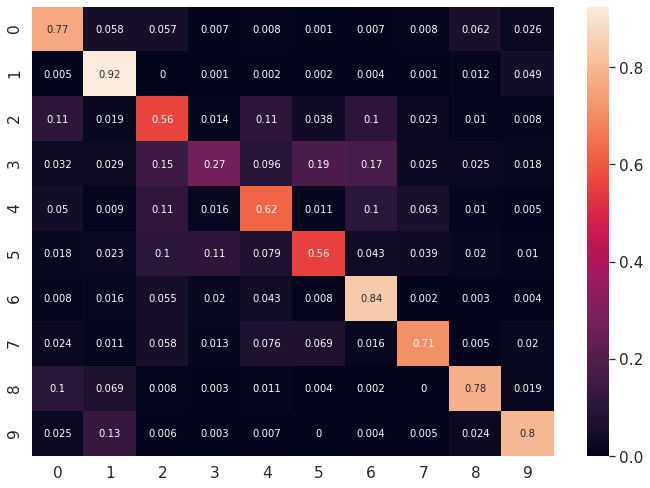

In [18]:
%matplotlib inline
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

def show_cm_matrix(prediction_labels, ground_truth_labels):
    cm = confusion_matrix(y_pred=prediction_labels,y_true=ground_truth_labels)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    sn.set(rc={'figure.figsize': (11.7,8.27)})
    sn.set(font_scale=1.4) #for label size
    sn.heatmap(cm, annot=True, annot_kws={"size": 10})# font size
    
show_cm_matrix(prediction_labels, ground_truth_labels)    

## Clean-up

위의 엔드포인트를 삭제 합니다.

In [19]:
sm_tf_predictor.delete_endpoint()

Gracefully stopping... (press Ctrl+C again to force)


# 6. 세이지 메이커 호스트 추론

- 아래는 약 10분 정도 소요 됩니다.

In [20]:
%%time 

from sagemaker.tensorflow import TensorFlowModel

sm_tf_model = TensorFlowModel(
                        model_data= artifact_path,
                        framework_version='2.4.1',
                        role=role,
        )

instance_type = 'ml.p2.xlarge'
endpoint_name = "sm-host-endpoint-cifar10-tf2-{}".format(int(time.time()))

sm_host_tf_predictor = sm_tf_model.deploy(
                           instance_type= instance_type, 
                           initial_instance_count=1, 
                           endpoint_name=endpoint_name,
                           wait=True,
                        )

update_endpoint is a no-op in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


---------------------!CPU times: user 381 ms, sys: 52.5 ms, total: 433 ms
Wall time: 10min 33s


In [21]:
%%time

ground_truth_labels, prediction_labels = inference_batch(sm_host_tf_predictor, eval_dataset)

batch_id: 0  - images shape: (1000, 32, 32, 3)
batch_id: 1  - images shape: (1000, 32, 32, 3)
batch_id: 2  - images shape: (1000, 32, 32, 3)
batch_id: 3  - images shape: (1000, 32, 32, 3)
batch_id: 4  - images shape: (1000, 32, 32, 3)
batch_id: 5  - images shape: (1000, 32, 32, 3)
batch_id: 6  - images shape: (1000, 32, 32, 3)
batch_id: 7  - images shape: (1000, 32, 32, 3)
batch_id: 8  - images shape: (1000, 32, 32, 3)
batch_id: 9  - images shape: (1000, 32, 32, 3)
ground_truth_labels:  (10000,)
prediction_labels:  (10000,)
CPU times: user 17.8 s, sys: 1.88 s, total: 19.7 s
Wall time: 36.9 s


In [22]:
compute_accuracy(prediction_labels, ground_truth_labels)    

'Average accuracy: 68.33%'

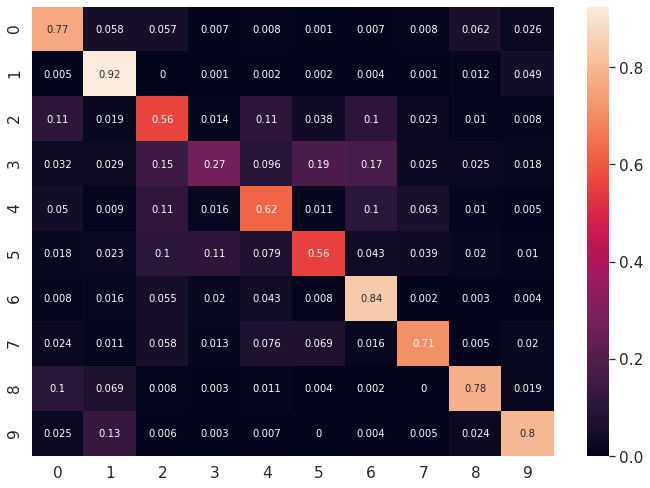

In [23]:
show_cm_matrix(prediction_labels, ground_truth_labels)    

# 7. 리소스 정리

In [26]:
sm_host_tf_predictor.delete_endpoint()